<a href="https://colab.research.google.com/github/Rakesh8086/Road-network-extraction/blob/main/U_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os

class CustomDataGenerator(Sequence):
    def __init__(self, image_dir, mask_dir=None, batch_size=32, target_size=(256, 256), shuffle=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.image_filenames = os.listdir(image_dir)

        if mask_dir:
            self.mask_filenames = os.listdir(mask_dir)
            assert len(self.image_filenames) == len(self.mask_filenames), "Number of images and masks must match."
        else:
            self.mask_filenames = None

        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, index):
        if index >= len(self):
            raise IndexError('DataGenerator object is out of range')
        batch_images = self.image_filenames[index * self.batch_size:(index + 1) * self.batch_size]
        return self.__data_generation(batch_images)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_filenames)

    def __data_generation(self, batch_images):
        X = np.empty((self.batch_size, *self.target_size, 3))  # Satellite images with 3 channels (RGB)
        if self.mask_dir:
            y = np.empty((self.batch_size, *self.target_size, 1))  # Masks converted to 1 channel
        else:
            y = None

        for i, image_name in enumerate(batch_images):
            # Load and preprocess satellite image (RGB)
            img_path = os.path.join(self.image_dir, image_name)
            image = load_img(img_path, target_size=self.target_size)  # Default is RGB
            X[i,] = img_to_array(image) / 255.0  # Normalize to [0, 1]

            # Load and preprocess mask image (convert RGB to grayscale)
            if self.mask_dir:
                mask_name = image_name.replace('_sat.jpg', '_mask.png')
                mask_path = os.path.join(self.mask_dir, mask_name)
                mask = load_img(mask_path, target_size=self.target_size, color_mode='grayscale')  # Load mask as grayscale
                y[i,] = img_to_array(mask) / 255.0

        return X, y

In [ ]:
train_gen = CustomDataGenerator(
    image_dir='/content/drive/MyDrive/road-extraction-DL/updated-data-resized/train_resize/satellite_resize',
    mask_dir='/content/drive/MyDrive/road-extraction-DL/updated-data-resized/train_resize/mask_resize'
)

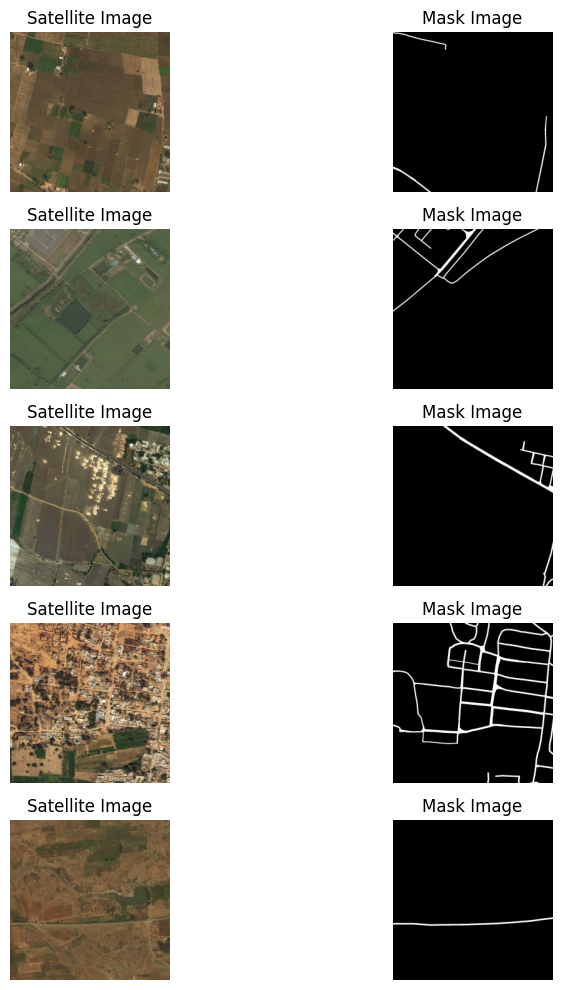

In [ ]:
import matplotlib.pyplot as plt

satellite_images, masks = train_gen[0]  # Get first bactch

num_images = 5

fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 2))

for i in range(num_images):
    # Display satellite image
    axes[i, 0].imshow(satellite_images[i])
    axes[i, 0].set_title('Satellite Image')
    axes[i, 0].axis('off')

    # Display mask image
    axes[i, 1].imshow(masks[i].squeeze(), cmap='gray')  # Squeeze to remove single-dimensional entries
    axes[i, 1].set_title('Mask Image')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
total_batches = len(train_gen)
print(f"Total batches in train_gen: {total_batches}")

Total batches in train_gen: 175


In [ ]:
val_gen = CustomDataGenerator(
    image_dir='/content/drive/MyDrive/road-extraction-DL/updated-data-resized/validation_resize/validation_satellite_resize',
    mask_dir='/content/drive/MyDrive/road-extraction-DL/updated-data-resized/validation_resize/validation_mask_resize'
)

Satellite image shape: (32, 256, 256, 3)
Mask image shape: (32, 256, 256, 1)


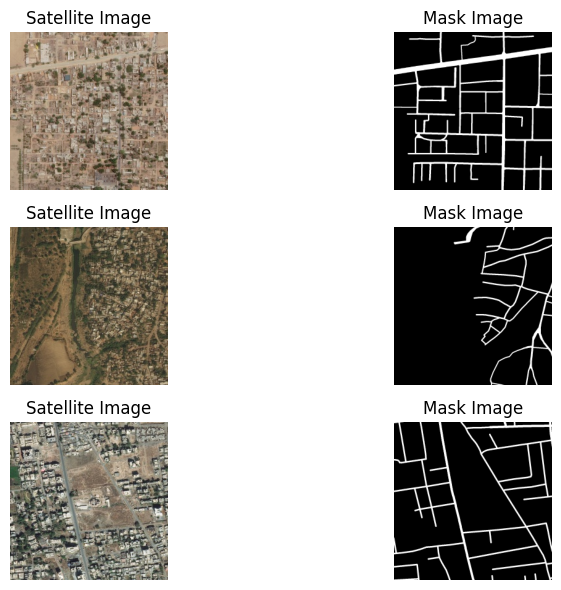

In [ ]:
import matplotlib.pyplot as plt

satellite_images, masks = val_gen[0]  # Get the first batch

num_images = 3

fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 2))

for i in range(num_images):
    axes[i, 0].imshow(satellite_images[i])
    axes[i, 0].set_title('Satellite Image')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(masks[i].squeeze(), cmap='gray')  # Squeeze to remove single-dimensional entries
    axes[i, 1].set_title('Mask Image')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
total_batches = len(val_gen)
print(f"Total batches in val_gen: {total_batches}")

Total batches in val_gen: 19


In [ ]:
test_gen = CustomDataGenerator(
    image_dir='/content/drive/MyDrive/road-extraction-DL/updated-data-resized/test_resize'
)

Satellite image shape: (32, 256, 256, 3)


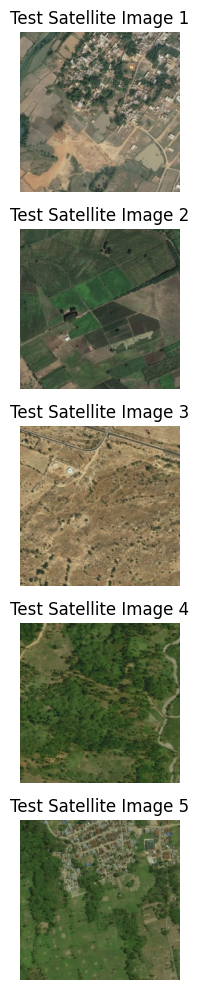

In [ ]:
import matplotlib.pyplot as plt

# Assuming test_gen yields (images, masks), you can access the images like this:
test_images, _ = test_gen[0]  # Ignore masks for visualization

num_images = 5

fig, axes = plt.subplots(num_images, 1, figsize=(10, num_images * 2))

for i in range(num_images):
    # Display satellite image
    axes[i].imshow(test_images[i])  # Access the individual image
    axes[i].set_title(f'Test Satellite Image {i + 1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

In [ ]:

def binary_unet_model(IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3): # Changed function name
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1) # 128*128*16

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2) # 64*64*32

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3) # 32*32*64

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4) # 16*16*128

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5) # at this point it 16*16*256
    # no more max pooling and downsampling to 8*8 as we may loose critical spatial information

    # Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4]) # 128+128 features = 256 feature maps at u6 now
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3]) # 64+64 features = 128 feature maps at u7 now
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2]) # 32+32 features = 64 feature maps at u8 now
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3) # 16+16 features = 32 feature maps at u9 now
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation="sigmoid")(c9)


    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [ ]:
model = binary_unet_model(IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 128, 32)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64, 64, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32, 32, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 128)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)    

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint

# Define the checkpoint callback with the specified path
checkpoint_callback = ModelCheckpoint(
    '/content/drive/MyDrive/road-extraction-DL/updated-data-resized/best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

In [ ]:
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    validation_data=val_gen,
    validation_steps=len(val_gen),
    epochs=15,
    verbose=1,
    callbacks=[checkpoint_callback]
)

Epoch 1/15
175/175 [==============================] - ETA: 0s - loss: 0.1791 - accuracy: 0.9432
Epoch 1: val_loss improved from inf to 0.22025, saving model to /content/drive/MyDrive/road-extraction-DL/updated-data-resized/best_model.keras
175/175 [==============================] - 1464s 7s/step - loss: 0.1791 - accuracy: 0.9432 - val_loss: 0.2203 - val_accuracy: 0.9444
Epoch 2/15
175/175 [==============================] - ETA: 0s - loss: 0.1514 - accuracy: 0.9450
Epoch 2: val_loss improved from 0.22025 to 0.16986, saving model to /content/drive/MyDrive/road-extraction-DL/updated-data-resized/best_model.keras
175/175 [==============================] - 537s 3s/step - loss: 0.1514 - accuracy: 0.9450 - val_loss: 0.1699 - val_accuracy: 0.9437
Epoch 3/15
175/175 [==============================] - ETA: 0s - loss: 0.1391 - accuracy: 0.9450
Epoch 3: val_loss improved from 0.16986 to 0.13194, saving model to /content/drive/MyDrive/road-extraction-DL/updated-data-resized/best_model.keras
175/175

KeyboardInterrupt: 

In [ ]:
model.save('/content/drive/MyDrive/road-extraction-DL/updated-data-resized/best_model.keras')

In [ ]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('/content/drive/MyDrive/road-extraction-DL/updated-data-resized/best_model.keras')

TypeError: Could not deserialize class 'Functional' because its parent module keras.src.engine.functional cannot be imported. Full object config: {'module': 'keras.src.engine.functional', 'class_name': 'Functional', 'config': {'name': 'model_1', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': [None, 256, 256, 3], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_2'}, 'registered_name': None, 'name': 'input_2', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_19', 'trainable': True, 'dtype': 'float32', 'filters': 16, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256, 3]}, 'name': 'conv2d_19', 'inbound_nodes': [[['input_2', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_9', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'noise_shape': None, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256, 16]}, 'name': 'dropout_9', 'inbound_nodes': [[['conv2d_19', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_20', 'trainable': True, 'dtype': 'float32', 'filters': 16, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256, 16]}, 'name': 'conv2d_20', 'inbound_nodes': [[['dropout_9', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_4', 'trainable': True, 'dtype': 'float32', 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256, 16]}, 'name': 'max_pooling2d_4', 'inbound_nodes': [[['conv2d_20', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_21', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 16]}, 'name': 'conv2d_21', 'inbound_nodes': [[['max_pooling2d_4', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_10', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'noise_shape': None, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 32]}, 'name': 'dropout_10', 'inbound_nodes': [[['conv2d_21', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_22', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 32]}, 'name': 'conv2d_22', 'inbound_nodes': [[['dropout_10', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_5', 'trainable': True, 'dtype': 'float32', 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 32]}, 'name': 'max_pooling2d_5', 'inbound_nodes': [[['conv2d_22', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_23', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 32]}, 'name': 'conv2d_23', 'inbound_nodes': [[['max_pooling2d_5', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_11', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'noise_shape': None, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 64]}, 'name': 'dropout_11', 'inbound_nodes': [[['conv2d_23', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_24', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 64]}, 'name': 'conv2d_24', 'inbound_nodes': [[['dropout_11', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_6', 'trainable': True, 'dtype': 'float32', 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 64]}, 'name': 'max_pooling2d_6', 'inbound_nodes': [[['conv2d_24', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_25', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 64]}, 'name': 'conv2d_25', 'inbound_nodes': [[['max_pooling2d_6', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_12', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'noise_shape': None, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 128]}, 'name': 'dropout_12', 'inbound_nodes': [[['conv2d_25', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_26', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 128]}, 'name': 'conv2d_26', 'inbound_nodes': [[['dropout_12', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_7', 'trainable': True, 'dtype': 'float32', 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 128]}, 'name': 'max_pooling2d_7', 'inbound_nodes': [[['conv2d_26', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_27', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 128]}, 'name': 'conv2d_27', 'inbound_nodes': [[['max_pooling2d_7', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_13', 'trainable': True, 'dtype': 'float32', 'rate': 0.3, 'noise_shape': None, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 256]}, 'name': 'dropout_13', 'inbound_nodes': [[['conv2d_27', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_28', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 256]}, 'name': 'conv2d_28', 'inbound_nodes': [[['dropout_13', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_4', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None, 'output_padding': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 256]}, 'name': 'conv2d_transpose_4', 'inbound_nodes': [[['conv2d_28', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_4', 'trainable': True, 'dtype': 'float32', 'axis': -1}, 'registered_name': None, 'build_config': {'input_shape': [[None, 32, 32, 128], [None, 32, 32, 128]]}, 'name': 'concatenate_4', 'inbound_nodes': [[['conv2d_transpose_4', 0, 0, {}], ['conv2d_26', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_29', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 256]}, 'name': 'conv2d_29', 'inbound_nodes': [[['concatenate_4', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_14', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'noise_shape': None, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 128]}, 'name': 'dropout_14', 'inbound_nodes': [[['conv2d_29', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_30', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 128]}, 'name': 'conv2d_30', 'inbound_nodes': [[['dropout_14', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_5', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None, 'output_padding': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 128]}, 'name': 'conv2d_transpose_5', 'inbound_nodes': [[['conv2d_30', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_5', 'trainable': True, 'dtype': 'float32', 'axis': -1}, 'registered_name': None, 'build_config': {'input_shape': [[None, 64, 64, 64], [None, 64, 64, 64]]}, 'name': 'concatenate_5', 'inbound_nodes': [[['conv2d_transpose_5', 0, 0, {}], ['conv2d_24', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_31', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 128]}, 'name': 'conv2d_31', 'inbound_nodes': [[['concatenate_5', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_15', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'noise_shape': None, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 64]}, 'name': 'dropout_15', 'inbound_nodes': [[['conv2d_31', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_32', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 64]}, 'name': 'conv2d_32', 'inbound_nodes': [[['dropout_15', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_6', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None, 'output_padding': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 64]}, 'name': 'conv2d_transpose_6', 'inbound_nodes': [[['conv2d_32', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_6', 'trainable': True, 'dtype': 'float32', 'axis': -1}, 'registered_name': None, 'build_config': {'input_shape': [[None, 128, 128, 32], [None, 128, 128, 32]]}, 'name': 'concatenate_6', 'inbound_nodes': [[['conv2d_transpose_6', 0, 0, {}], ['conv2d_22', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_33', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 64]}, 'name': 'conv2d_33', 'inbound_nodes': [[['concatenate_6', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_16', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'noise_shape': None, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 32]}, 'name': 'dropout_16', 'inbound_nodes': [[['conv2d_33', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_34', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 32]}, 'name': 'conv2d_34', 'inbound_nodes': [[['dropout_16', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_7', 'trainable': True, 'dtype': 'float32', 'filters': 16, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None, 'output_padding': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 32]}, 'name': 'conv2d_transpose_7', 'inbound_nodes': [[['conv2d_34', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_7', 'trainable': True, 'dtype': 'float32', 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[None, 256, 256, 16], [None, 256, 256, 16]]}, 'name': 'concatenate_7', 'inbound_nodes': [[['conv2d_transpose_7', 0, 0, {}], ['conv2d_20', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_35', 'trainable': True, 'dtype': 'float32', 'filters': 16, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256, 32]}, 'name': 'conv2d_35', 'inbound_nodes': [[['concatenate_7', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_17', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'noise_shape': None, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256, 16]}, 'name': 'dropout_17', 'inbound_nodes': [[['conv2d_35', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_36', 'trainable': True, 'dtype': 'float32', 'filters': 16, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256, 16]}, 'name': 'conv2d_36', 'inbound_nodes': [[['dropout_17', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_37', 'trainable': True, 'dtype': 'float32', 'filters': 1, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256, 16]}, 'name': 'conv2d_37', 'inbound_nodes': [[['conv2d_36', 0, 0, {}]]]}], 'input_layers': [['input_2', 0, 0]], 'output_layers': [['conv2d_37', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': [None, 256, 256, 3]}, 'compile_config': {'optimizer': 'adam', 'loss': 'binary_crossentropy', 'metrics': ['accuracy'], 'loss_weights': None, 'weighted_metrics': None, 'run_eagerly': None, 'steps_per_execution': None, 'jit_compile': None}}

In [ ]:
!pip install --upgrade tensorflow

In [ ]:
test_gen = CustomDataGenerator(
    image_dir='/content/drive/MyDrive/road-extraction-DL/updated-data-resized/test_resize',
    mask_dir=None,  # Masks are not needed for testing
    batch_size=1,
    target_size=(256, 256),
    shuffle=False
)

In [ ]:
predictions = model.predict(test_gen)

1101/1101 [==============================] - 48s 43ms/step


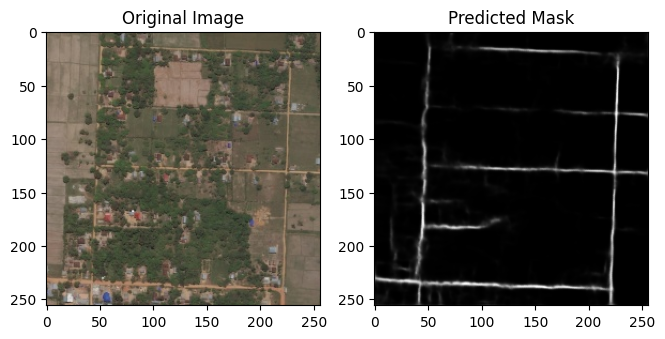

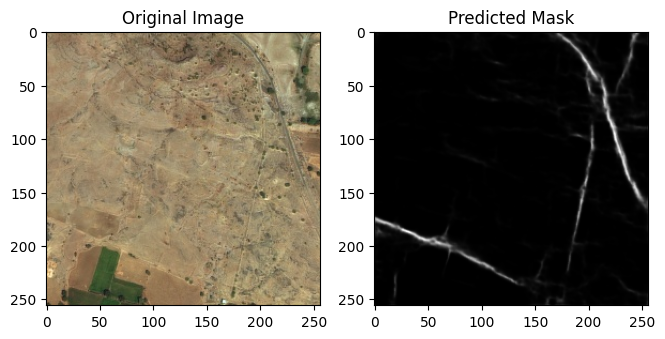

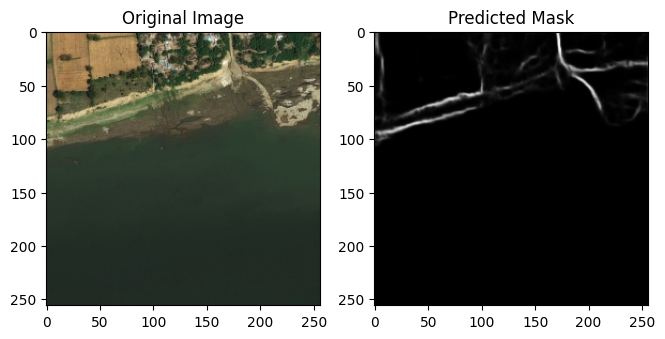

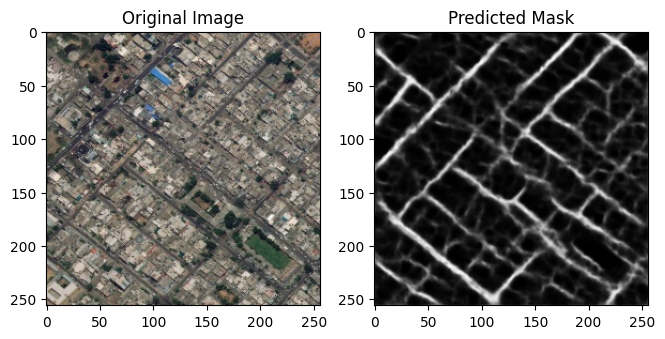

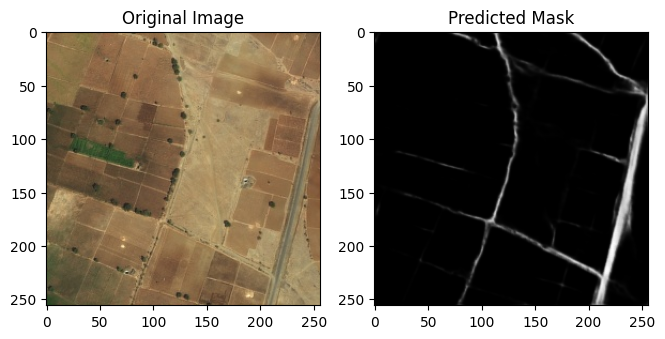

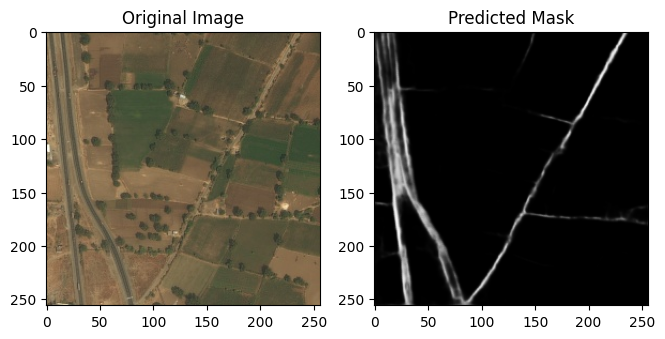

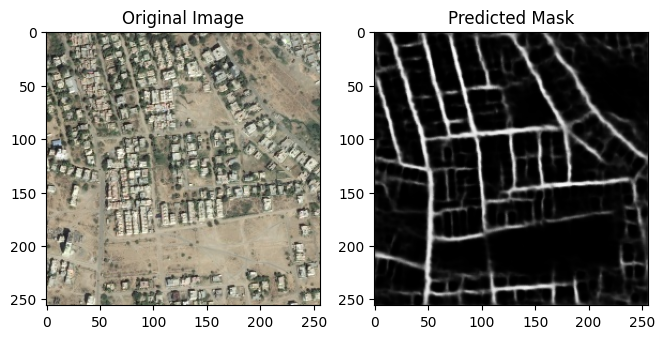

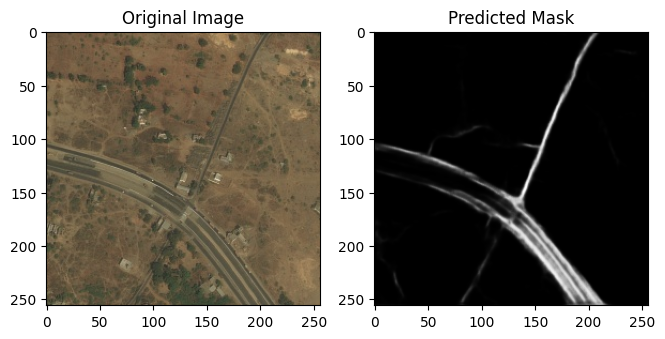

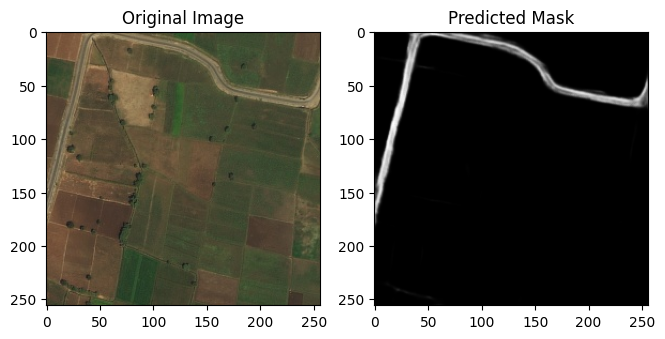

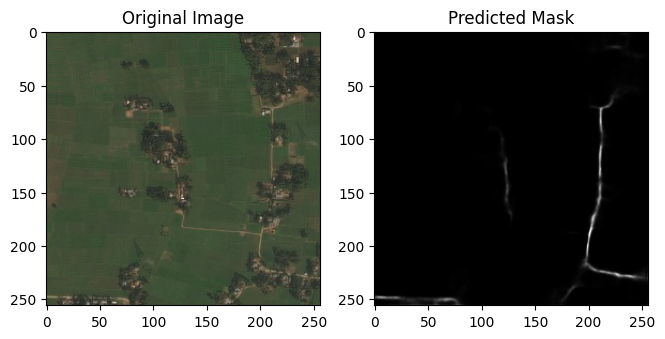

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize some predictions
num_images_to_show = 10  # Adjust as needed

for i in range(num_images_to_show):
    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(test_gen[i][0][0])  # Get the first test image
    plt.title('Original Image')

    # Predicted Mask
    plt.subplot(1, 3, 2)
    plt.imshow(predictions[i].squeeze(), cmap='gray')  # Squeeze to remove channels if needed
    plt.title('Predicted Mask')

    plt.show()

In [ ]:
############################### new images ######################################

In [ ]:
# Define the directory containing your resized images
test_images_dir = '/content/drive/MyDrive/road-extraction-DL/updated-data-resized/new_images_resize'  # Change this to your resized images directory

# Prepare to store predictions
predictions = []

In [ ]:
from PIL import Image

# Loop through each image in the directory
for image_name in os.listdir(test_images_dir):
    img_path = os.path.join(test_images_dir, image_name)

    # Load and preprocess the image
    with Image.open(img_path) as img:
        img_resized = img.resize((256, 256))
        img_array = np.array(img_resized) / 255.0

        # Check if the image has 3 channels (RGB)
        if img_array.shape[-1] == 3:
            img_array = np.expand_dims(img_array, axis=0)

            # Make prediction
            prediction = model.predict(img_array)
            predictions.append(prediction[0])  # Store the prediction (removing batch dimension)
        else:
            print(f"Image {image_name} does not have 3 channels. Skipping...")

# Convert predictions to binary masks
binary_masks = [(pred > 0.5).astype(np.uint8) for pred in predictions]

# Save the predicted masks
output_masks_dir = '/content/drive/MyDrive/road-extraction-DL/updated-data-resized/new_images'
os.makedirs(output_masks_dir, exist_ok=True)

for i, mask in enumerate(binary_masks):
    mask = np.squeeze(mask)  # Remove unnecessary dimensions if any

    # If the mask still has 3 dimensions, take only the first channel
    if len(mask.shape) == 3:
        mask = mask[:, :, 0] # Select the first channel of the mask

    mask_image = Image.fromarray(mask.astype(np.uint8) * 255, mode='L')  # mode='L' ensures a grayscale image
    mask_image.save(os.path.join(output_masks_dir, f"predicted_mask_{i}.png"))

print("Predictions have been made and saved.")

1/1 [==============================] - 0s 51ms/step
Predictions have been made and saved.


In [ ]:
################## Test images ######################

In [ ]:
import os
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
import matplotlib.pyplot as plt

test_image_dir = '/content/drive/MyDrive/road-extraction-DL/data(not in use)/resized/valid_resize'
save_dir = '/content/drive/MyDrive/road-extraction-DL/data(not in use)/resized/valid_resize'

os.makedirs(save_dir, exist_ok=True)

test_images = os.listdir(test_image_dir)

for image_name in test_images:
    img_path = os.path.join(test_image_dir, image_name)
    image = load_img(img_path, target_size=(256, 256))
    image_array = img_to_array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)

    # Make prediction
    prediction = model.predict(image_array)

    # Process prediction to binary mask (thresholding)
    predicted_mask = (prediction.squeeze() > 0.5).astype(np.uint8)  # Binarize the prediction

    mask_save_path = os.path.join(save_dir, f'predicted_mask_{image_name}')
    plt.imsave(mask_save_path, predicted_mask, cmap='gray')  # Save as grayscale image

print("Predictions saved successfully!")


NameError: name 'model' is not defined

In [ ]:
model = binary_unet_model()

# Load weights
model.load_weights('/content/drive/MyDrive/road-extraction-DL/updated-data-resized/best_model.keras')

In [ ]:
import keras
print(keras.__version__)

3.4.1


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.17.0


In [ ]:
model = binary_unet_model()  # Rebuild the model architecture
model.load_weights('/content/drive/MyDrive/road-extraction-DL/updated-data-resized/best_model.keras')

In [ ]:
model.save('/content/drive/MyDrive/road-extraction-DL/updated-data-resized/best_model', save_format='tf')


ValueError: The `save_format` argument is deprecated in Keras 3. Please remove this argument and pass a file path with either `.keras` or `.h5` extension.Received: save_format=tf